## This code takes the college basketball data and models it using gradient boosted classifer trees

In [1]:
#import packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import StratifiedKFold
from hyperopt import fmin, tpe, anneal, hp, STATUS_OK, Trials, space_eval
import hyperopt.pyll.stochastic
from hyperopt.pyll import scope
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
#creating functions to evaluate model fit

def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


def evaluate_classification(model, test_features, test_labels, extra = False):
    
    predictions = model.predict(test_features)
    
    accuracy = sum(predictions == test_labels)/len(test_labels)
    
    class_rep = classification_report(test_labels, predictions, digits = 4)
    
    cf_matrix = confusion_matrix(test_labels, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = ['Predicted Loss', 'Predicted Win'],
               yticklabels = ['Actual Loss', 'Actual Win'])
    

    print('Model Performance\n')
    print('Accuracy = ',(accuracy),'\n')
    print('Classification Report\n')
    print(class_rep)
    plt.show()
    
    
    
    if extra == True:
        
        probas = model.predict_proba(test_features)[:, 1]
        
        print('Area Under the Curve =', roc_auc_score(test_labels, probas))
        
        
        
        roc_values = []
        for thresh in np.linspace(0, 1, 100):
            preds = get_preds(thresh, probas)
            tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            roc_values.append([tpr, fpr])
            
        tpr_values, fpr_values = zip(*roc_values)
        
        fig, ax = plt.subplots(figsize=(10,7))
        ax.plot(fpr_values, tpr_values)
        ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
        plt.title('Receiver Operating Characteristic Curve', fontsize=18)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)
        plt.legend(fontsize=12)
        
        plt.show()
        
def compare_classification(model1, model2, test_features1, test_features2, test_labels):
    
    predictions1 = model1.predict(test_features1)
    predictions2 = model2.predict(test_features2)
    
    probas1 = model1.predict_proba(test_features1)[:, 1]
    probas2 = model2.predict_proba(test_features2)[:, 1]
    
    auc1 = roc_auc_score(test_labels, probas1)
    auc2 = roc_auc_score(test_labels, probas2)
    
    accuracy1 = sum(predictions1 == test_labels)/len(test_labels)
    accuracy2 = sum(predictions2 == test_labels)/len(test_labels)
    
    class_rep1 = classification_report(test_labels, predictions1, digits = 4)
    class_rep2 = classification_report(test_labels, predictions2, digits = 4)
    
    acc_diff = accuracy2 - accuracy1
    auc_diff = auc2 - auc1
    
    
    if acc_diff > 0:
        result_acc = 'Accuracy: Model 2 better'
    elif acc_diff == 0:
        result_acc = "Accuracy: Models perform the same"
    else:
        result_acc = "Accuracy: Model 1 better"
        
    if auc_diff > 0:
        result_auc = 'AUC: Model 2 better'
    elif auc_diff == 0:
        result_auc = "AUC: Models perform the same"
    else:
        result_auc = "AUC: Model 1 better"
    
    print('           Model 1 Performance   ', 'Model 2 Performance', '  Difference (Model2 - Model1)')
    print('Accuracy: ',(accuracy1),"   ",(accuracy2),"   ",(acc_diff),"    ",result_acc)
    print('AUC: ',(auc1),"   ",(auc2),"   ",(auc_diff),"    ",result_auc)
    
    
def evaluate_test(models, test_features, val_features, test_outcomes, val_outcomes, sort_var = 'acc'):
    
    full_result = pd.DataFrame()
    
    for x in range(len(models)):
          
        predictions_test = models[x].predict(test_features[x])
        probs_test = models[x].predict_proba(test_features[x])[:, 1]
        
        predictions_val = models[x].predict(val_features[x])
        probs_val = models[x].predict_proba(val_features[x])[:, 1]
        
        auc_test = roc_auc_score(test_outcomes, probs_test)
        accuracy_test = sum(predictions_test == test_outcomes)/len(test_outcomes)
        
        
        auc_val = roc_auc_score(val_outcomes, probs_val)
        accuracy_val = sum(predictions_val == val_outcomes)/len(val_outcomes)
        
        current_result = pd.DataFrame({'model_name': [name_of_object(models[x])],
                                       'model':[models[x]],
                                       'data_name': [name_of_object(test_features[x])],
                                       'data':[test_features[x].to_dict()],
                                       'test_acc':[accuracy_test],
                                       'val_acc':[accuracy_val],
                                       'test_auc':[auc_test],
                                       'val_auc':[auc_val]})
        
        full_result = full_result.append(current_result, ignore_index = True)
        
    full_result.reset_index(drop=True, inplace = True)
        
    full_result['test_acc_rank'] = full_result['test_acc'].rank(ascending = False)
    full_result['test_auc_rank'] = full_result['test_auc'].rank(ascending = False)
    
    #if sort_var == 'acc':
        
    full_result.sort_values(by = ['test_acc_rank','test_auc_rank'], inplace=True)
        
    #elif sort_var == 'auc': 
    
    #    full_result.sort_values(by = ['auc_rank'], inplace=True)
        
    #else:
    
    #    full_result = full_result
        
    return(full_result)

def name_of_object(arg):
    # check __name__ attribute (functions)
    try:
        return arg.__name__
    except AttributeError:
        pass

    for name, value in globals().items():
        if value is arg and not name.startswith('_'):
            return name

## Importing data and conducting minor cleaning including converting the outcome varible to 0/1, then setting up training and testing sets

In [3]:
#import data
full_data = pd.read_csv("College Data/Weighted Mean Converted Data.csv")

In [4]:
#inspect data columns
full_data.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'Location', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA',
       'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1',
       'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1',
       'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1',
       'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1',
       'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1'],
      dtype='object')

In [5]:
full_data.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,Location,FG,FGA,...,ORB%.1,FT/FGA.1,DRB%.1,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,A,23.000000,57.000000,...,0.264706,0.174603,0.813953,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,N,31.000000,60.833333,...,0.291657,0.214480,0.806891,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,N,28.600000,59.700000,...,0.139543,0.301987,0.795111,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,N,27.733333,57.466667,...,0.249515,0.118953,0.856104,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,A,26.095238,58.190476,...,0.281522,0.178352,0.713698,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669


In [6]:
#converting Location variable with one-hot encoding (dummy coding)

full_data_adv = pd.get_dummies(full_data, columns = ['Location'])

full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0


In [7]:
full_data_adv.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%',
       'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1',
       'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1',
       'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1', 'TOV%.1',
       'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1',
       'POSS.1', 'OffRt.1', 'DefRt.1', 'Location_A', 'Location_H',
       'Location_N'],
      dtype='object')

In [8]:
#creating overtime variable

full_data_adv['OT'] = full_data_adv['W/L'].str.split().str[2].str[0:2]
full_data_adv['OT'].fillna(0, inplace = True)
full_data_adv['OT'].replace('OT', 1, inplace = True)

In [9]:
#examining outcome variable values
full_data_adv['W/L'].unique()

array(['L', 'W', 'L\xa0(2 OT)', 'L\xa0(1 OT)', 'W\xa0(1 OT)',
       'W\xa0(4 OT)', 'W\xa0(2 OT)', 'W\xa0(3 OT)', 'L\xa0(3 OT)',
       'L\xa0(4 OT)'], dtype=object)

In [10]:
#removing extra text in win loss variable
full_data_adv['W/L'] = full_data_adv['W/L'].str.split().str[0]
full_data_adv['W/L'].unique()

array(['L', 'W'], dtype=object)

In [11]:
#Converting outcome variable from string to numeric
full_data_adv.replace({"W/L": {"W":1, "L":0}}, inplace = True)

In [12]:
#looking at cleaned data
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [13]:
#examining number of rows and columns of cleaned data
full_data_adv.shape

(10693, 67)

In [14]:
#examining all variable types
pd.options.display.max_rows = 70
print(full_data_adv.dtypes)
pd.options.display.max_rows = 10

Date           object
G               int64
Opp            object
W/L             int64
Opp.1           int64
Tm              int64
Team           object
FG            float64
FGA           float64
FG%           float64
3P            float64
3PA           float64
3P%           float64
FT            float64
FTA           float64
FT%           float64
ORB           float64
TRB           float64
AST           float64
STL           float64
BLK           float64
TOV           float64
PF            float64
eFG           float64
TOV%          float64
ORB%          float64
FT/FGA        float64
DRB%          float64
AST%          float64
TS%           float64
3PAr          float64
DRB           float64
POSS          float64
OffRt         float64
DefRt         float64
FG.1          float64
FGA.1         float64
FG%.1         float64
3P.1          float64
3PA.1         float64
3P%.1         float64
FT.1          float64
FTA.1         float64
FT%.1         float64
ORB.1         float64
TRB.1     

In [15]:
#droping any duplicate rows
full_data_adv.dropna().drop_duplicates()
full_data_adv.shape

(10693, 67)

In [16]:
#columns that will not be used as features



fields_to_drop = ['G', 'Date', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'OT']

#fields_to_keep = []



In [17]:
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [18]:
#creating feature data and examining number of rows and columns

X = full_data_adv.drop(columns = fields_to_drop)

print(X.shape)
X.columns

(10693, 59)


Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%',
       'FT/FGA', 'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt',
       'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1',
       'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1',
       'PF.1', 'eFG.1', 'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1',
       'TS%.1', '3PAr.1', 'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H', 'Location_N'],
      dtype='object')

In [19]:
#Create outcome data

y = full_data_adv['W/L'].values

y.shape

(10693,)

In [20]:
#Create training, validation, and test data

train_ratio = 0.60
validation_ratio = 0.25
test_ratio = 0.15


# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size= test_ratio,
                                                    stratify = y,
                                                    random_state = 17)

 #test is now 10% of the initial data set
 #validation is now 20% of the initial data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=validation_ratio/(train_ratio + validation_ratio),
                                                 stratify = y_train,
                                                 random_state = 17) 

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])
print(y_train.sum()/len(y_train), y_val.sum()/len(y_val), y_test.sum()/len(y_test))

(6415, 59) (2674, 59) (1604, 59)
0.5999251847002712 0.25007013934349576 0.15000467595623304
0.5016367887763056 0.5014958863126402 0.5018703241895262


In [21]:
#Standardizing the predictor variables into Z scores

#take categorical variables and one-hot encode
dummy_train = X_train[['Location_A','Location_H','Location_N']]
dummy_train.reset_index(drop = True, inplace = True)
dummy_val = X_val[['Location_A','Location_H','Location_N']]
dummy_val.reset_index(drop = True, inplace = True)
dummy_test = X_test[['Location_A','Location_H','Location_N']]
dummy_test.reset_index(drop = True, inplace = True)

#create subset of data with just continuous variables
X_train1 = X_train.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_val1 =  X_val.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_test1 =  X_test.drop(['Location_A','Location_H','Location_N'], axis = 1)

#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_val_std = pd.DataFrame(scaler.transform(X_val1))
X_val_std.columns = X_val1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#combine continuous and categorical variables
X_train_d = pd.concat([X_train_std, dummy_train], axis = 1)
X_val_d = pd.concat([X_val_std, dummy_val], axis = 1)
X_test_d = pd.concat([X_test_std, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full = X_train_d#.drop(['Location_N'], axis = 1)
X_val_full = X_val_d#.drop(['Location_N'], axis = 1)
X_test_full = X_test_d#.drop(['Location_N'], axis = 1)


In [22]:
X_test_full

,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,...,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N
0,-1.249129,-0.305708,-1.364429,-1.058969,-1.216123,-0.348753,-1.576551,-1.445925,-0.495891,0.310059,...,-0.467870,-0.533652,-0.873550,-0.325636,0.308051,-1.169114,-0.028589,1,0,0
1,-0.038381,0.195136,-0.211669,0.619742,0.708113,0.087561,-0.581999,-0.745891,0.277800,0.393785,...,-0.311867,0.691640,0.198411,-0.813232,-2.264681,0.738368,-0.571685,0,0,1
2,-0.069258,0.232584,-0.278840,-1.391449,-1.112967,-0.997524,0.360914,0.652408,-0.348070,0.453044,...,-1.585952,-0.575867,-1.080463,-1.059249,-0.204870,-0.146006,0.278852,1,0,0
3,-1.574791,-0.022063,-1.951030,0.989469,1.569720,0.066076,-1.235984,-0.796162,-1.896355,-1.230355,...,0.854956,-1.643134,0.097897,-0.392791,0.210299,-1.444137,-0.199283,1,0,0
4,0.206912,-0.312830,0.602268,-1.471550,-1.500519,-0.585367,0.563455,0.771300,-0.441882,0.370440,...,0.609687,-0.009464,-1.431434,-0.042579,-0.831106,0.852571,0.311600,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,0.223310,-0.499817,0.752379,-0.574399,-0.795088,0.161528,-0.419103,0.444826,-1.418375,-0.552913,...,-0.299935,1.080383,1.328014,-0.919313,-0.455035,0.317331,0.895728,0,1,0
1600,1.740761,0.833721,1.529873,2.196408,1.612578,1.446239,-0.352875,-0.774325,1.151852,-1.057521,...,0.114051,0.104250,-1.290346,-0.419114,-0.421157,-0.277237,1.413296,0,1,0
1601,-0.138134,0.534585,-0.598653,0.320718,0.524576,-0.073375,-1.326467,-1.302169,-0.369508,-0.013752,...,0.074200,0.385029,-1.322779,-0.611933,-0.250328,0.472489,1.059287,1,0,0
1602,0.974679,0.828716,0.454264,1.443141,2.090314,-0.200199,0.293838,-0.048579,0.751098,-0.781921,...,-0.041935,-0.357377,-0.465027,0.771844,0.673762,-0.665160,0.183106,1,0,0


## Running a basic gradient boosted tree model and examining the results

In [23]:
#create basic logistic regression object

gbc = GradientBoostingClassifier(random_state = 0)

In [24]:
#fit basic logistic regression model to training data
gbc.fit(X_train_full,y_train)

GradientBoostingClassifier(random_state=0)

Model Performance

Accuracy =  0.6828721017202692 

Classification Report

              precision    recall  f1-score   support

           0     0.6830    0.6789    0.6810      1333
           1     0.6827    0.6868    0.6848      1341

    accuracy                         0.6829      2674
   macro avg     0.6829    0.6829    0.6829      2674
weighted avg     0.6829    0.6829    0.6829      2674



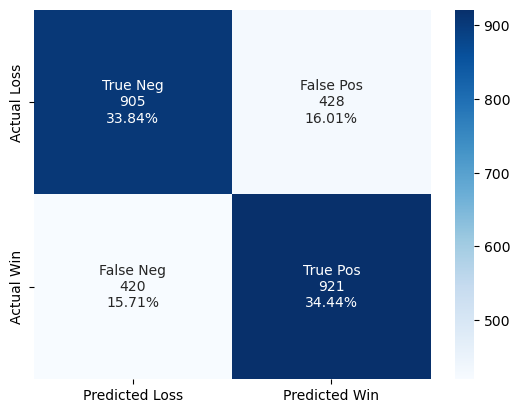

Area Under the Curve = 0.7353795943393007


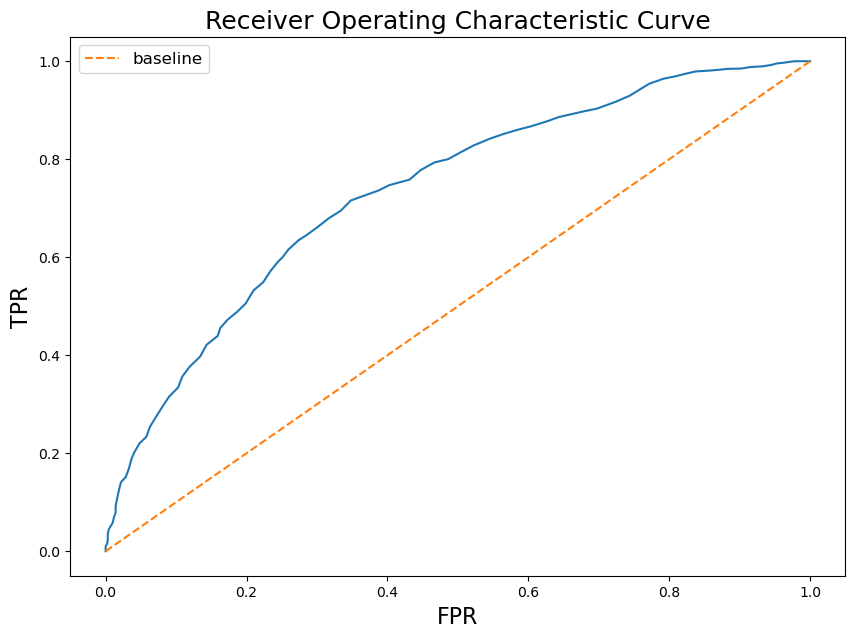

In [25]:
#evaluate performance on training data

evaluate_classification(gbc, X_val_full, y_val, extra = True)

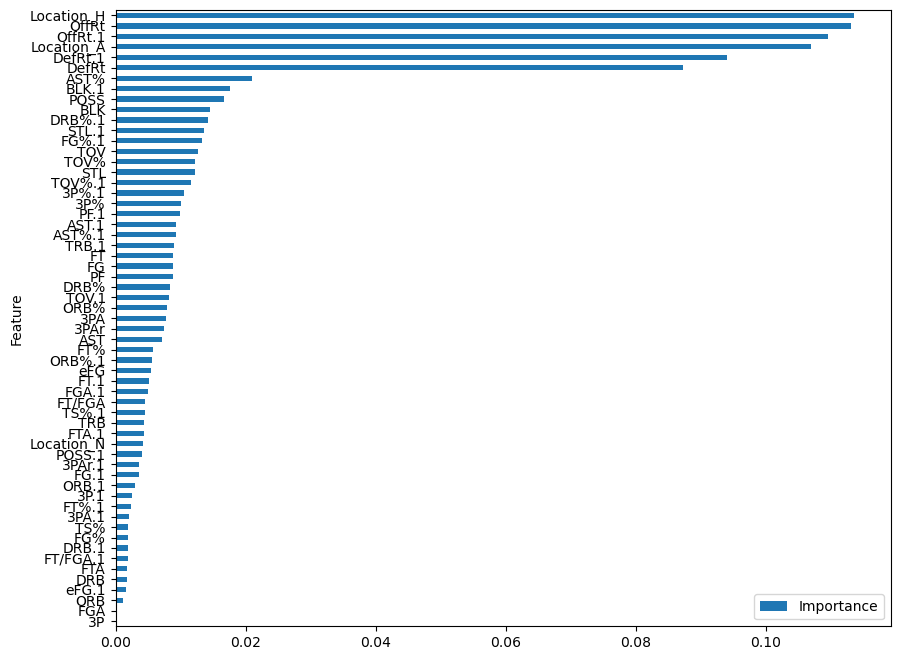

In [26]:
#examining variable importance
coefficients = gbc.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [27]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
3           3P    0.000000
1          FGA    0.000153
9          ORB    0.001173
44       eFG.1    0.001668
24         DRB    0.001688
7          FTA    0.001720
47    FT/FGA.1    0.001886
52       DRB.1    0.001901
2          FG%    0.001981
22         TS%    0.001991
32       3PA.1    0.002130
36       FT%.1    0.002448
31        3P.1    0.002590
37       ORB.1    0.002939
28        FG.1    0.003631
51      3PAr.1    0.003649
53      POSS.1    0.004029
58  Location_N    0.004223
35       FTA.1    0.004319
10         TRB    0.004446
50       TS%.1    0.004505
19      FT/FGA    0.004531
29       FGA.1    0.004987
34        FT.1    0.005209
16         eFG    0.005471
46      ORB%.1    0.005674
8          FT%    0.005732
11         AST    0.007184
23        3PAr    0.007418
4          3PA    0.007688
18        ORB%    0.007875
42       TOV.1    0.008252
20        DRB%    0.008387
15          PF    0.008812
0           FG    0.008821
6           FT    0.008884
3

## Note: Many of out variables are not that important, so we can probably remove some of them later, but first lets optimize the model for this full set of variables

## Now lets use hyperopt to optimize the gradient boosted trees
## Note: This process, even with hyperopt, can take some tweaking of the paramters that are used and what values to use for them

In [28]:
#assign values for hyperopt to explore as it searches for optimal parameters
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 1,1000,1)),
    'loss': hp.choice('loss', ['log_loss','exponential']),
    'learning_rate': hp.uniform('learning_rate', 0.0,0.1),
    'criterion': hp.choice('criterion', ['friedman_mse','squared_error']),
    'max_depth': hp.choice('max_depth',
                           [None, scope.int(hp.quniform('max_depth_uni', 1,20,1))]),
    'max_features': hp.choice('max_features',
        [None, 'log2', 'sqrt', hp.uniform('max_features_uni', 0.0,1.0)]),
    'min_samples_split': hp.uniform('min_samples_split', 0.0, 0.9),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0,1.0),
    'subsample': hp.uniform('subsample', 0.0,1.0),
    'ccp_alpha': hp.uniform('ccp_alpha', 0,0.03),
    'random_state': 0
}

In [29]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    
    model = GradientBoostingClassifier(**params)
    model.fit(X_train_full, y_train)
    
    y_pred_train = model.predict(X_train_full)
    y_pred_val = model.predict(X_val_full)
    
    acc = accuracy_score(y_val, y_pred_val)
    
    if acc > best:
        best = acc
        print('new best:', best, params, count)
        
    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'train_loss': -accuracy_score(y_train, y_pred_train)}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=500, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                       
0.5014958863126402                                                              
{'ccp_alpha': 0.01452554717515473, 'criterion': 'squared_error', 'learning_rate': 0.03239990357154339, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.6517423997488939, 'min_samples_split': 0.7955339629253539, 'n_estimators': 620, 'random_state': 0, 'subsample': 0.8136554076402878}
1                                                                               
new best:                                                                       
0.6537023186237846                                                              
{'ccp_alpha': 0.004746417060137752, 'criterion': 'squared_error', 'learning_rate': 0.09324514936730748, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 0.33486009438808095, 'min_samples_split': 0.183855826809146, 'n_estimators': 988, 'random_sta

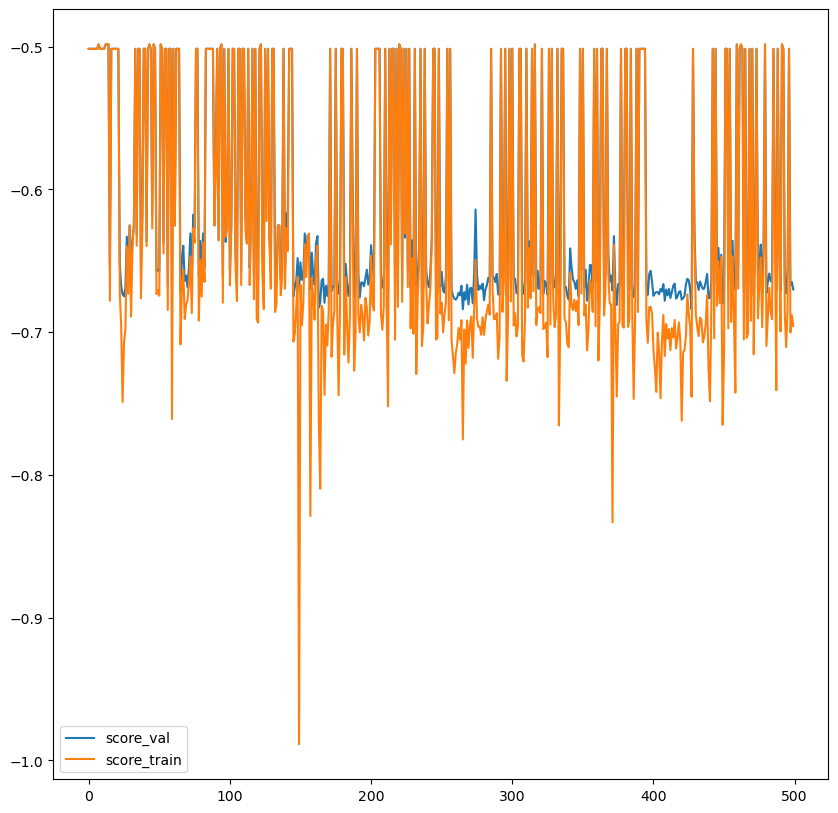

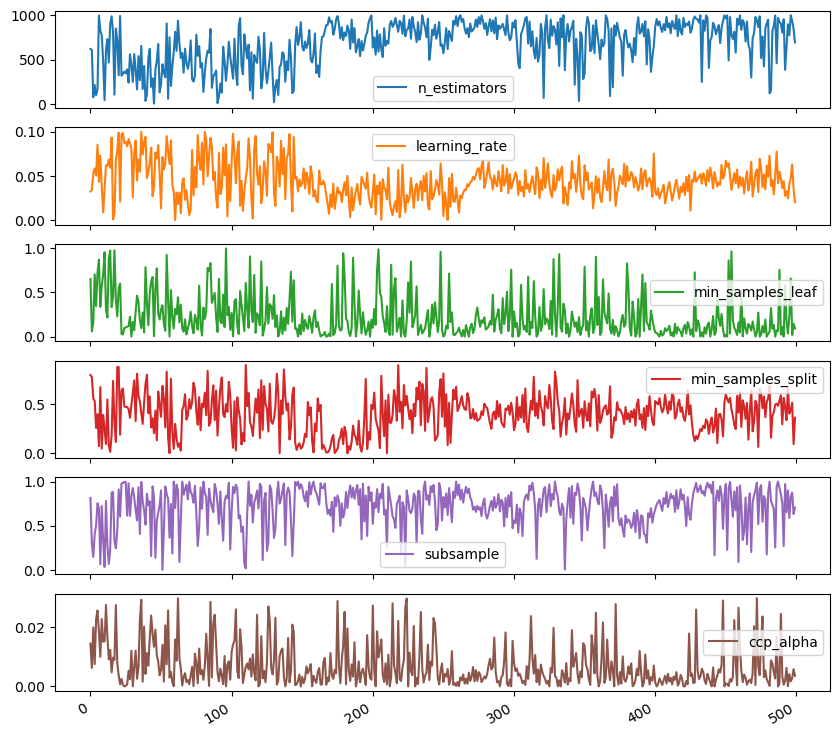

In [30]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss']] for x in trials.trials])

results2=np.array([x['train_loss'] for x in trials.results])

results_loss=pd.DataFrame(results,
                           columns=['score_val'])

results_loss['score_train'] = results2

results_loss.plot(subplots=False,figsize=(10, 10))




results3=np.array([[x['misc']['vals']['n_estimators'][0],
                   x['misc']['vals']['learning_rate'][0],
                   x['misc']['vals']['min_samples_leaf'][0],
                   x['misc']['vals']['min_samples_split'][0],
                   x['misc']['vals']['subsample'][0],
                   x['misc']['vals']['ccp_alpha'][0]] for x in trials.trials])

results_df1=pd.DataFrame(results3,
                           columns=['n_estimators', 'learning_rate', 'min_samples_leaf',
                                   'min_samples_split',
                                   'subsample', 'ccp_alpha'])

results_df1.plot(subplots=True,figsize=(10, 10))


plt.show()

In [31]:
#examine best parameters
best1 = space_eval(space, best)
best1

{'ccp_alpha': 0.0009414359150335965,
 'criterion': 'squared_error',
 'learning_rate': 0.03448351315246737,
 'loss': 'exponential',
 'max_depth': 15,
 'max_features': 0.7396987236556847,
 'min_samples_leaf': 0.00046225158960965483,
 'min_samples_split': 0.44819663931845716,
 'n_estimators': 853,
 'random_state': 0,
 'subsample': 0.8694605952284311}

In [32]:
#train model using best parameters from search
hyp_gbc = GradientBoostingClassifier(n_estimators = best1['n_estimators'],
                                    loss = best1['loss'],
                                    learning_rate = best1['learning_rate'],
                                    criterion = best1['criterion'],
                                    max_depth = best1['max_depth'],
                                    max_features = best1['max_features'],
                                     min_samples_leaf = best1['min_samples_leaf'],
                                     min_samples_split = best1['min_samples_split'],
                                    subsample = best1['subsample'],
                                     ccp_alpha = best1['ccp_alpha'],
                                    random_state = best1['random_state'])

hyp_gbc.fit(X_train_full, y_train)

GradientBoostingClassifier(ccp_alpha=0.0009414359150335965,
                           criterion='squared_error',
                           learning_rate=0.03448351315246737,
                           loss='exponential', max_depth=15,
                           max_features=0.7396987236556847,
                           min_samples_leaf=0.00046225158960965483,
                           min_samples_split=0.44819663931845716,
                           n_estimators=853, random_state=0,
                           subsample=0.8694605952284311)

In [33]:
#examine accuracy on training data
y_pred = hyp_gbc.predict(X_train_full)
print('Training Data Classification Report for estimator: ',
      str(hyp_gbc).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  GradientBoostingClassifier

               precision    recall  f1-score   support

           0       0.78      0.77      0.77      3197
           1       0.77      0.78      0.78      3218

    accuracy                           0.78      6415
   macro avg       0.78      0.78      0.78      6415
weighted avg       0.78      0.78      0.78      6415



In [34]:
#examine accuracy on test data
y_pred = hyp_gbc.predict(X_val_full)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_gbc).split('(')[0])
print('\n', classification_report(y_val, y_pred))

Test Data Classification Report for estimator:  GradientBoostingClassifier

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1333
           1       0.68      0.69      0.69      1341

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.6839940164547494 

Classification Report

              precision    recall  f1-score   support

           0     0.6837    0.6812    0.6825      1333
           1     0.6842    0.6868    0.6855      1341

    accuracy                         0.6840      2674
   macro avg     0.6840    0.6840    0.6840      2674
weighted avg     0.6840    0.6840    0.6840      2674



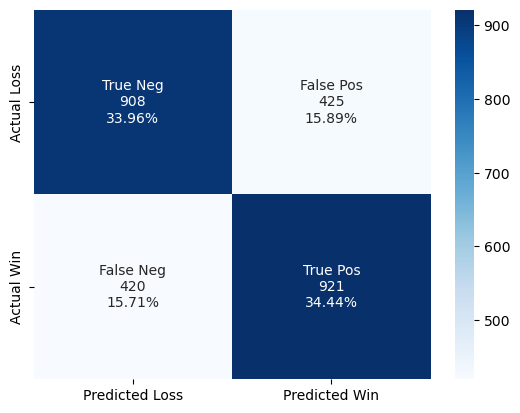

Area Under the Curve = 0.7391730482956309


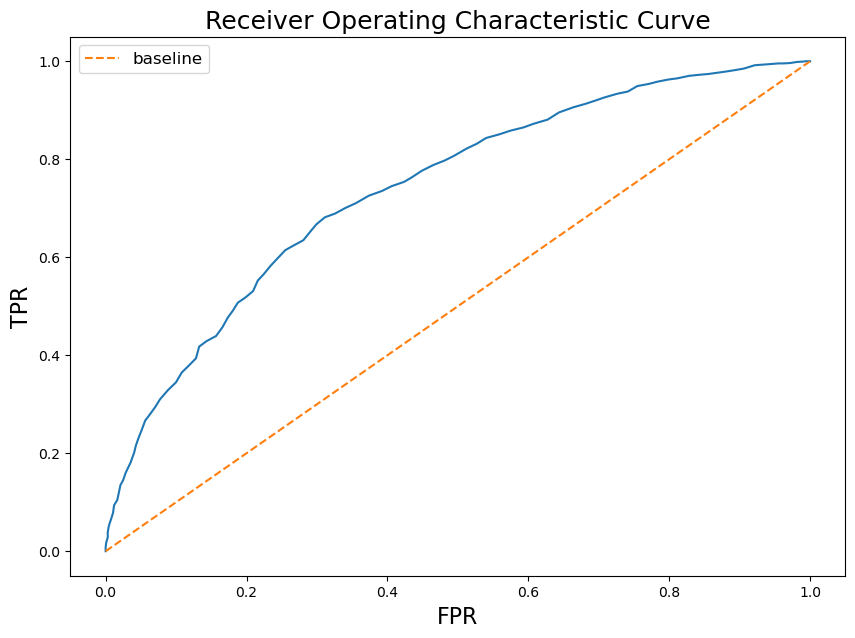

In [35]:
#further investigate accuracy on test data
evaluate_classification(hyp_gbc, X_val_full, y_val, extra = True)

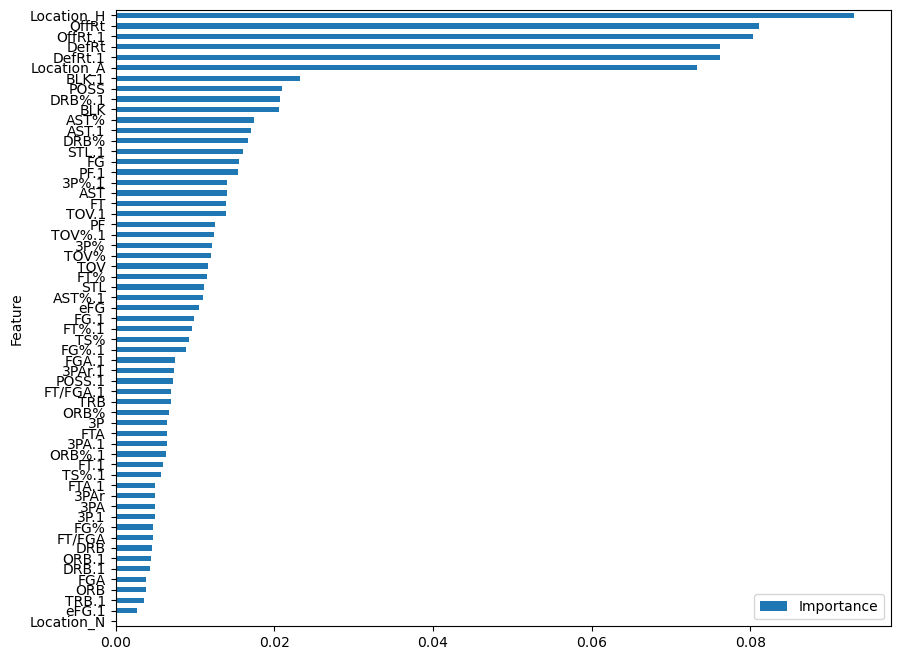

In [36]:
#examining variable importance
coefficients = hyp_gbc.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [37]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
58  Location_N    0.000000
44       eFG.1    0.002656
38       TRB.1    0.003621
9          ORB    0.003784
1          FGA    0.003847
52       DRB.1    0.004401
37       ORB.1    0.004447
24         DRB    0.004643
19      FT/FGA    0.004692
2          FG%    0.004746
31        3P.1    0.004993
4          3PA    0.004994
23        3PAr    0.005007
35       FTA.1    0.005013
50       TS%.1    0.005729
34        FT.1    0.005979
46      ORB%.1    0.006324
32       3PA.1    0.006471
7          FTA    0.006503
3           3P    0.006531
18        ORB%    0.006759
10         TRB    0.006972
47    FT/FGA.1    0.007054
53      POSS.1    0.007290
51      3PAr.1    0.007376
29       FGA.1    0.007483
30       FG%.1    0.008941
22         TS%    0.009291
36       FT%.1    0.009700
28        FG.1    0.009868
16         eFG    0.010524
49      AST%.1    0.011036
12         STL    0.011099
8          FT%    0.011494
14         TOV    0.011656
17        TOV%    0.012086
5

In [38]:
#compare original logistic regression to optimized
compare_classification(gbc, hyp_gbc, X_val_full, X_val_full, y_val)


           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6828721017202692     0.6839940164547494     0.0011219147344802005      Accuracy: Model 2 better
AUC:  0.7353795943393007     0.7391730482956309     0.0037934539563302394      AUC: Model 2 better


## The optimized model performs better than the base model and we see that the variable importance even more so shows there are only a few important variables

## It may be the case that some variables are not that important, as a result we can try using Recrusive Feature Selection to narrow down our variable list

In [39]:
#creating a base Logistic Regression model object
# then creating a recursive feature elimination object
# then fitting to the training data
GBC_estimator = GradientBoostingClassifier(random_state=0)
GBC_select = RFECV(GBC_estimator, step=1, cv=5, n_jobs = -1)
GBC_selector = GBC_select.fit(X_train_full, y_train)


In [40]:
#examining how many of the original features were retained
(GBC_selector.support_).sum()

47

In [41]:
#examining which features were retained
X_train_full.columns[GBC_selector.support_]

Index(['FG', '3PA', '3P%', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%', '3PAr', 'DRB',
       'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3P%.1',
       'FT.1', 'FTA.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1',
       'TOV%.1', 'ORB%.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'POSS.1',
       'OffRt.1', 'DefRt.1', 'Location_A', 'Location_H', 'Location_N'],
      dtype='object')

In [42]:
#examining which features were removed
X_train_full.columns[~GBC_selector.support_]

Index(['FGA', 'FG%', '3P', 'FTA', 'ORB', 'TS%', '3PA.1', 'FT%.1', 'ORB.1',
       'eFG.1', 'FT/FGA.1', 'DRB.1'],
      dtype='object')

In [43]:
#creating training data the contains only the retained features
X_train_full_rfe = X_train_full[X_train_full.columns[GBC_selector.support_]]
X_val_full_rfe = X_val_full[X_val_full.columns[GBC_selector.support_]]
X_test_full_rfe = X_test_full[X_train_full.columns[GBC_selector.support_]]

In [44]:
#creating a base logistic regression object
gbc_rfe = GradientBoostingClassifier(random_state = 0)

In [45]:
#fitting the model to the subset of features
gbc_rfe.fit(X_train_full_rfe, y_train)

GradientBoostingClassifier(random_state=0)

Model Performance

Accuracy =  0.681750186985789 

Classification Report

              precision    recall  f1-score   support

           0     0.6840    0.6722    0.6780      1333
           1     0.6796    0.6913    0.6854      1341

    accuracy                         0.6818      2674
   macro avg     0.6818    0.6817    0.6817      2674
weighted avg     0.6818    0.6818    0.6817      2674



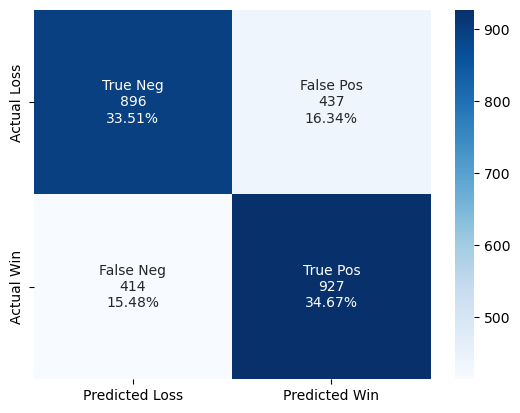

Area Under the Curve = 0.7361191528307133


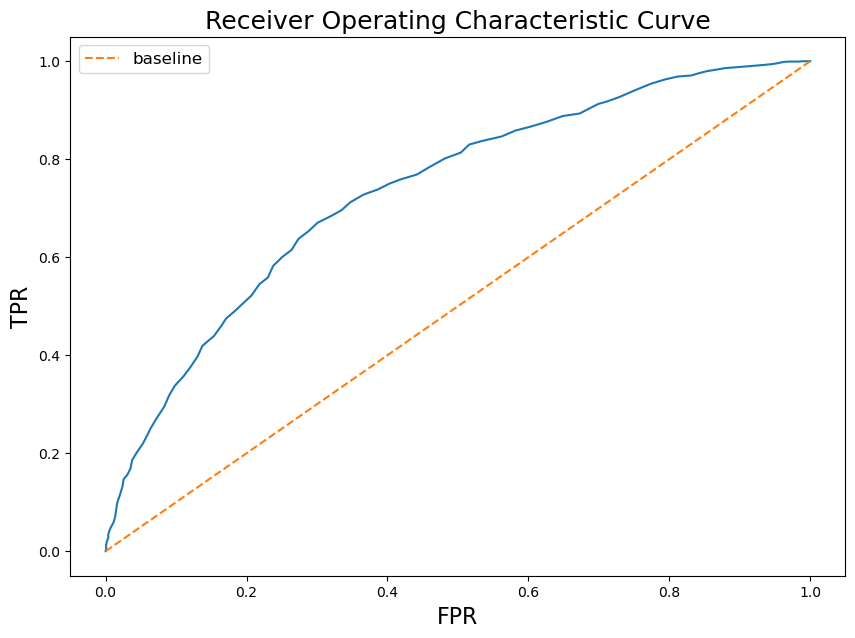

In [46]:
#evaluating reduced features model
evaluate_classification(gbc_rfe, X_val_full_rfe, y_val, extra = True)

In [47]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_gbc, gbc_rfe, X_val_full, X_val_full_rfe, y_val)


           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6839940164547494     0.681750186985789     -0.002243829468960401      Accuracy: Model 1 better
AUC:  0.7391730482956309     0.7361191528307133     -0.003053895464917633      AUC: Model 1 better


## The optimized gradient boosted trees with the full variable set model performs better
## Lets also try optimizing the RFE model

In [48]:
#assign values for hyperopt to explore as it searches for optimal parameters
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 1,1000,1)),
    'loss': hp.choice('loss', ['log_loss','exponential']),
    'learning_rate': hp.uniform('learning_rate', 0.0,0.1),
    'criterion': hp.choice('criterion', ['friedman_mse','squared_error']),
    'max_depth': hp.choice('max_depth',
                           [None, scope.int(hp.quniform('max_depth_uni', 1,20,1))]),
    'max_features': hp.choice('max_features',
        [None, 'log2', 'sqrt', hp.uniform('max_features_uni', 0.0,1.0)]),
    'min_samples_split': hp.uniform('min_samples_split', 0.0, 0.9),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0,1.0),
    'subsample': hp.uniform('subsample', 0.0,1.0),
    'ccp_alpha': hp.uniform('ccp_alpha', 0,0.03),
    'random_state': 0
}

In [49]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    
    model = GradientBoostingClassifier(**params)
    model.fit(X_train_full_rfe, y_train)
    
    y_pred_train = model.predict(X_train_full_rfe)
    y_pred_val = model.predict(X_val_full_rfe)
    
    acc = accuracy_score(y_val, y_pred_val)
    
    if acc > best:
        best = acc
        print('new best:', best, params, count)
        
    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'train_loss': -accuracy_score(y_train, y_pred_train)}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=500, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                       
0.5014958863126402                                                              
{'ccp_alpha': 0.01452554717515473, 'criterion': 'squared_error', 'learning_rate': 0.03239990357154339, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.6517423997488939, 'min_samples_split': 0.7955339629253539, 'n_estimators': 620, 'random_state': 0, 'subsample': 0.8136554076402878}
1                                                                               
new best:                                                                       
0.6537023186237846                                                              
{'ccp_alpha': 0.004746417060137752, 'criterion': 'squared_error', 'learning_rate': 0.09324514936730748, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 0.33486009438808095, 'min_samples_split': 0.183855826809146, 'n_estimators': 988, 'random_sta

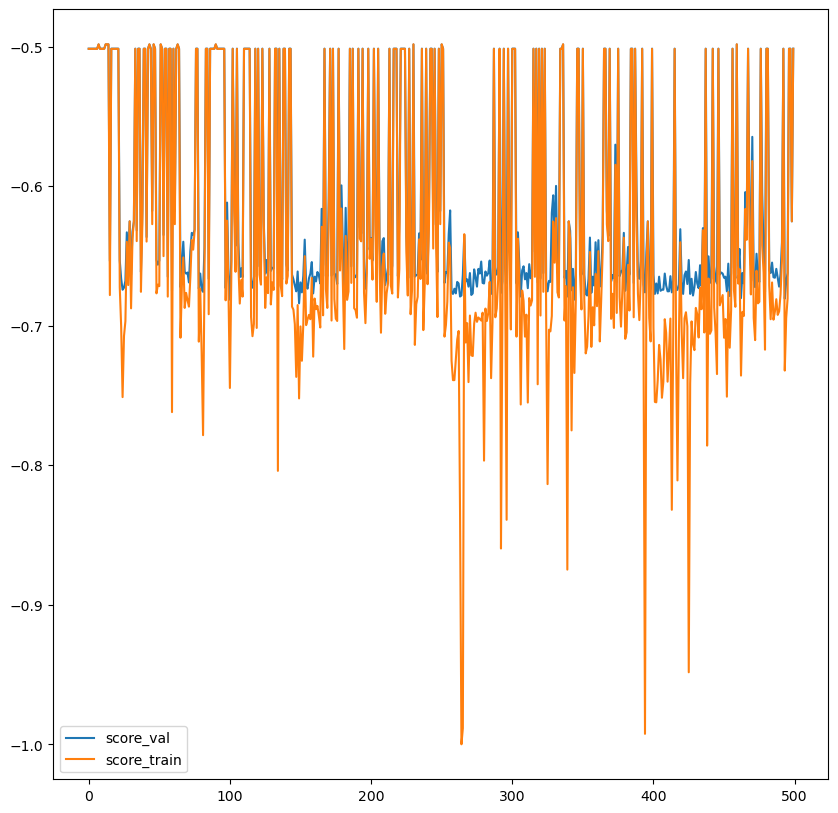

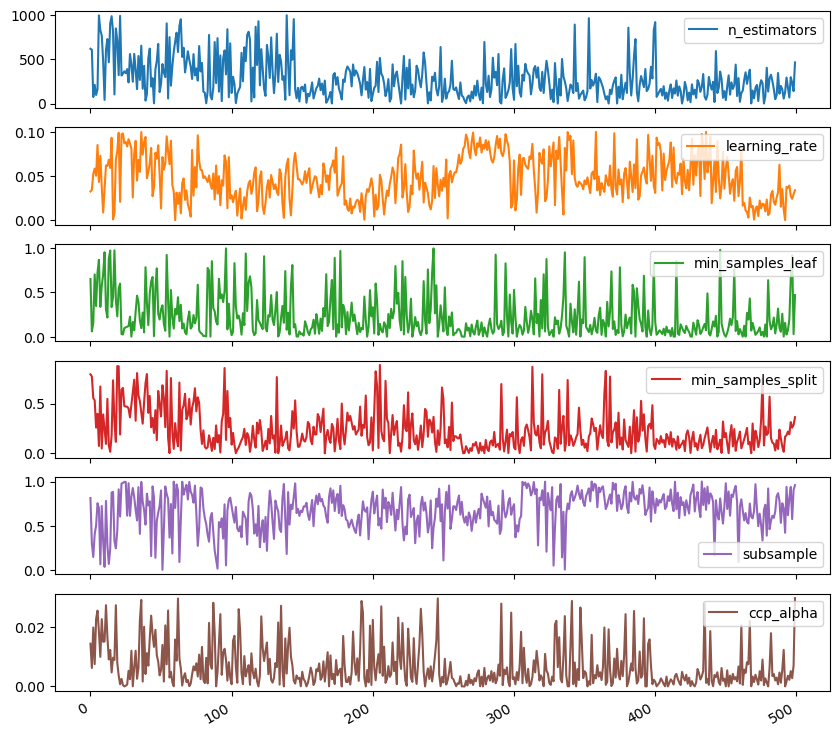

In [50]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss']] for x in trials.trials])

results2=np.array([x['train_loss'] for x in trials.results])

results_loss=pd.DataFrame(results,
                           columns=['score_val'])

results_loss['score_train'] = results2

results_loss.plot(subplots=False,figsize=(10, 10))




results3=np.array([[x['misc']['vals']['n_estimators'][0],
                   x['misc']['vals']['learning_rate'][0],
                   x['misc']['vals']['min_samples_leaf'][0],
                   x['misc']['vals']['min_samples_split'][0],
                   x['misc']['vals']['subsample'][0],
                   x['misc']['vals']['ccp_alpha'][0]] for x in trials.trials])

results_df1=pd.DataFrame(results3,
                           columns=['n_estimators', 'learning_rate', 'min_samples_leaf',
                                   'min_samples_split',
                                   'subsample', 'ccp_alpha'])

results_df1.plot(subplots=True,figsize=(10, 10))


plt.show()

In [51]:
#examine best parameters
best2 = space_eval(space, best)
best2

{'ccp_alpha': 4.4213943939740274e-05,
 'criterion': 'squared_error',
 'learning_rate': 0.043634443054281,
 'loss': 'exponential',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 0.030252310100417096,
 'min_samples_split': 0.12071534290406516,
 'n_estimators': 179,
 'random_state': 0,
 'subsample': 0.6701745134901581}

In [52]:
#train model using best parameters from search
hyp_gbc_rfe = GradientBoostingClassifier(n_estimators = best2['n_estimators'],
                                    loss = best2['loss'],
                                    learning_rate = best2['learning_rate'],
                                    criterion = best2['criterion'],
                                    max_depth = best2['max_depth'],
                                    max_features = best2['max_features'],
                                     min_samples_leaf = best2['min_samples_leaf'],
                                     min_samples_split = best2['min_samples_split'],
                                    subsample = best2['subsample'],
                                     ccp_alpha = best2['ccp_alpha'],
                                    random_state = best2['random_state'])

hyp_gbc_rfe.fit(X_train_full_rfe, y_train)

GradientBoostingClassifier(ccp_alpha=4.4213943939740274e-05,
                           criterion='squared_error',
                           learning_rate=0.043634443054281, loss='exponential',
                           max_depth=None,
                           min_samples_leaf=0.030252310100417096,
                           min_samples_split=0.12071534290406516,
                           n_estimators=179, random_state=0,
                           subsample=0.6701745134901581)

In [53]:
#examine accuracy on training data
y_pred = hyp_gbc_rfe.predict(X_train_full_rfe)
print('Training Data Classification Report for estimator: ',
      str(hyp_gbc).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  GradientBoostingClassifier

               precision    recall  f1-score   support

           0       0.75      0.75      0.75      3197
           1       0.75      0.75      0.75      3218

    accuracy                           0.75      6415
   macro avg       0.75      0.75      0.75      6415
weighted avg       0.75      0.75      0.75      6415



In [54]:
#examine accuracy on test data
y_pred = hyp_gbc_rfe.predict(X_val_full_rfe)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_gbc).split('(')[0])
print('\n', classification_report(y_val, y_pred))

Test Data Classification Report for estimator:  GradientBoostingClassifier

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1333
           1       0.68      0.69      0.69      1341

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.6839940164547494 

Classification Report

              precision    recall  f1-score   support

           0     0.6837    0.6812    0.6825      1333
           1     0.6842    0.6868    0.6855      1341

    accuracy                         0.6840      2674
   macro avg     0.6840    0.6840    0.6840      2674
weighted avg     0.6840    0.6840    0.6840      2674



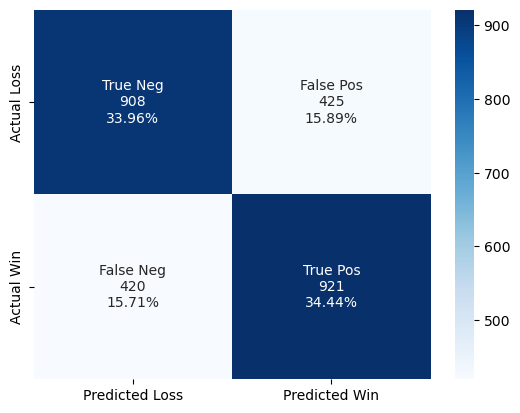

Area Under the Curve = 0.737889170279147


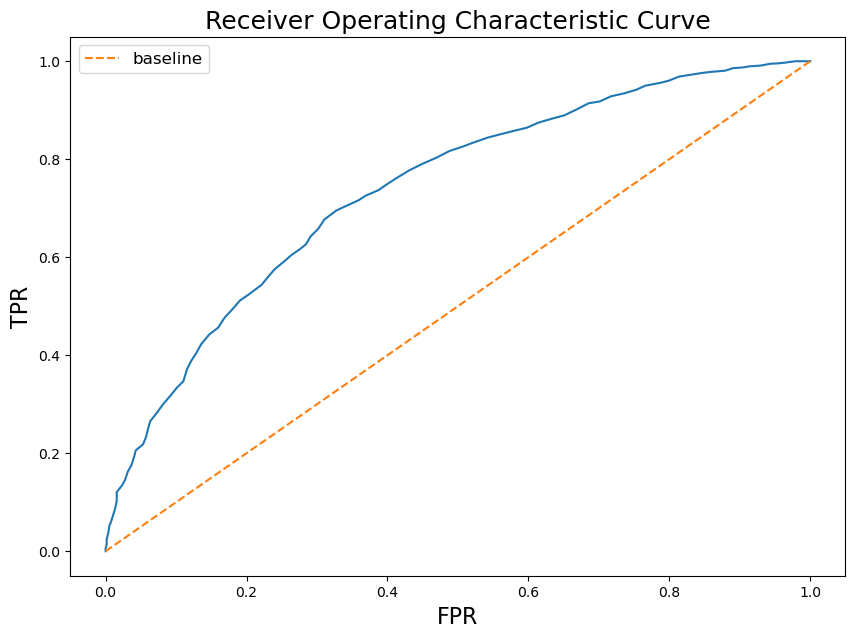

In [55]:
#further investigate accuracy on test data
evaluate_classification(hyp_gbc_rfe, X_val_full_rfe, y_val, extra = True)

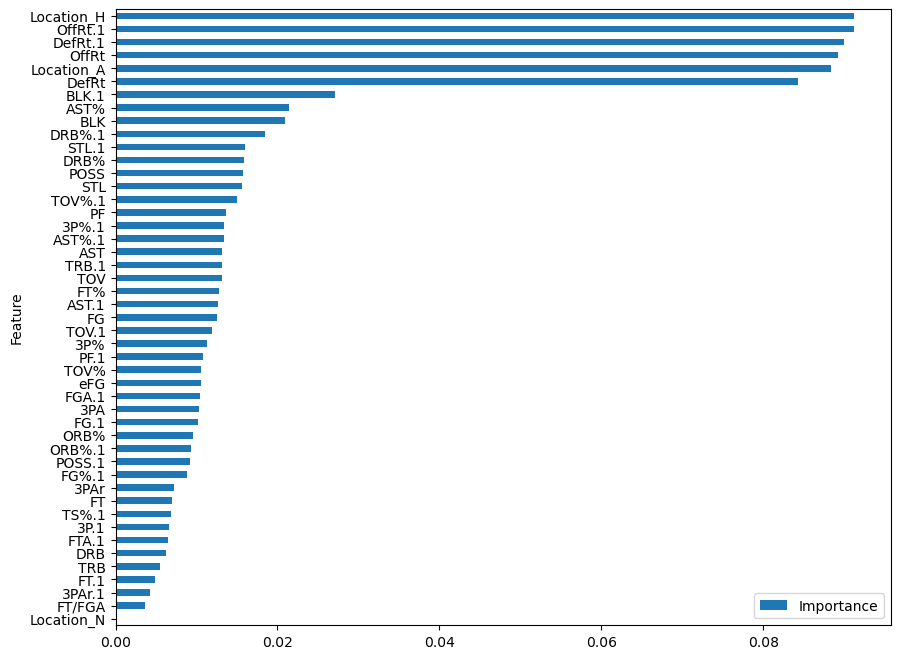

In [56]:
#examining variable importance
coefficients = hyp_gbc_rfe.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train_full_rfe.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [57]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
46  Location_N    0.000000
14      FT/FGA    0.003625
40      3PAr.1    0.004209
27        FT.1    0.004928
5          TRB    0.005435
18         DRB    0.006235
28       FTA.1    0.006513
25        3P.1    0.006632
39       TS%.1    0.006803
3           FT    0.006989
17        3PAr    0.007191
24       FG%.1    0.008807
41      POSS.1    0.009145
36      ORB%.1    0.009361
13        ORB%    0.009515
22        FG.1    0.010148
1          3PA    0.010340
23       FGA.1    0.010449
11         eFG    0.010586
12        TOV%    0.010588
34        PF.1    0.010834
2          3P%    0.011329
33       TOV.1    0.011865
0           FG    0.012584
30       AST.1    0.012677
4          FT%    0.012740
9          TOV    0.013140
29       TRB.1    0.013150
6          AST    0.013199
38      AST%.1    0.013376
26       3P%.1    0.013407
10          PF    0.013633
35      TOV%.1    0.015048
7          STL    0.015581
19        POSS    0.015779
15        DRB%    0.015838
3

In [58]:
#compare original logistic regression to optimized
compare_classification(hyp_gbc, hyp_gbc_rfe, X_val_full, X_val_full_rfe, y_val)


           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6839940164547494     0.6839940164547494     0.0      Accuracy: Models perform the same
AUC:  0.7391730482956309     0.737889170279147     -0.0012838780164838859      AUC: Model 1 better


## The optimized gradient boosted tree model using the full set of variables actualy performs the same as the RFE modelon accurac but has slightly better AUC value.

## Next, just like we did with Logistic Regression we should examine if there are high correlations between certain variables by first visually inspecting a correlation plot
## Although gradient boosted trees are not as affected by high correlations as a regression is, it is still important to examine the variable relationships and try to trim out variables that are highly correlated but do not contribute that much to the model.

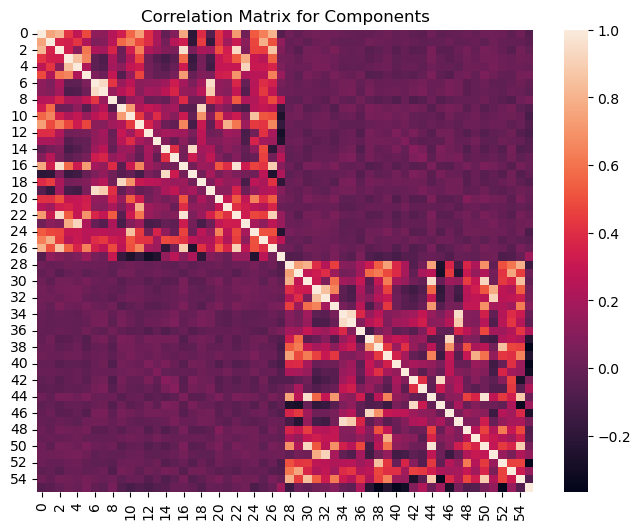

In [59]:
#examining the correlations between the standardized continuous variables
fig, ax = plt.subplots(figsize=(8,6))
corr_mat = np.corrcoef(X_train_std.transpose())
sns.heatmap(corr_mat)
ax.set(title = 'Correlation Matrix for Components')
plt.show()

## We see that the variables from team 1 have low to no correlation with team 2, however we also see that some of the variables within a team have high correlations. Lets explore that further.

In [60]:
#create a dataframe of correlations
corr_frame = pd.DataFrame()


for i in X_train_std.columns:
    for j in X_train_std.columns:
        value = X_train_std[i].corr(X_train_std[j])
        df2 = {'Var1': i, 'Correlation': value, 'Var2': j}
        corr_frame = corr_frame.append(df2, ignore_index = True)

corr_frame = corr_frame.reset_index(drop = True)
#filter correlations above 0.7
pd.options.display.max_rows = 70
corr_frame = corr_frame[(corr_frame['Correlation'] < 0.99) & (corr_frame['Correlation'] > 0.7)]
display(corr_frame)
pd.options.display.max_rows = 10

,Correlation,Var1,Var2
1,0.750800,FG,FGA
2,0.810116,FG,FG%
11,0.730237,FG,AST
16,0.767375,FG,eFG
22,0.713083,FG,TS%
...,...,...,...
2997,0.759284,POSS.1,FGA.1
3052,0.787904,OffRt.1,FG.1
3054,0.840411,OffRt.1,FG%.1
3068,0.872358,OffRt.1,eFG.1


## Many of the high correlations have to do with a variable and its % version, lets look at the VIF values to help

In [61]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_std.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_std.values, i) for i in range(len(X_train_std.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

/Users/piercecappelli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF Scores
0,FG,157.122001
1,FGA,inf
2,FG%,2976.402139
3,3P,329.657213
4,3PA,344.779005
5,3P%,17.000457
6,FT,180.905004
7,FTA,inf
8,FT%,9.897294
9,ORB,inf


## Many variables have extremely high VIF scores, lets remove several and see how it improves our model. We can also remember that our variable importance chart previous indicated that many of our variables were not that important

In [62]:
#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_val_std = pd.DataFrame(scaler.transform(X_val1))
X_val_std.columns = X_val1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#remove certain variables with high VIF factors
X_train_sub = X_train_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                            'FT', 'FT.1',
                            'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

X_val_sub = X_val_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                           'FT', 'FT.1',
                           'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

X_test_sub = X_test_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                           'FT', 'FT.1',
                           'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

#combine continuous and categorical variables
X_train_sub_d = pd.concat([X_train_sub, dummy_train], axis = 1)
X_val_sub_d = pd.concat([X_val_sub, dummy_val], axis = 1)
X_test_sub_d = pd.concat([X_test_sub, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full_sub = X_train_sub_d.drop(['Location_N'], axis = 1)
X_val_full_sub = X_val_sub_d.drop(['Location_N'], axis = 1)
X_test_full_sub = X_test_sub_d.drop(['Location_N'], axis = 1)

## Reinspect the VIF values

In [63]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_full_sub.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_full_sub.values, i) for i in range(len(X_train_full_sub.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

,Attribute,VIF Scores
0,STL,1.715770
1,BLK,1.231980
2,PF,1.536697
3,TOV%,1.643367
4,ORB%,1.545432
5,FT/FGA,1.297366
6,DRB%,1.709964
7,AST%,1.356740
8,3PAr,1.333849
9,POSS,2.377327


## VIF scores look great, lets try modelling with this reduced set of variables

In [64]:
gbc_sub = GradientBoostingClassifier(random_state = 0)

gbc_sub.fit(X_train_full_sub, y_train)

GradientBoostingClassifier(random_state=0)

Model Performance

Accuracy =  0.6787584143605087 

Classification Report

              precision    recall  f1-score   support

           0     0.6787    0.6752    0.6769      1333
           1     0.6788    0.6823    0.6806      1341

    accuracy                         0.6788      2674
   macro avg     0.6788    0.6787    0.6787      2674
weighted avg     0.6788    0.6788    0.6788      2674



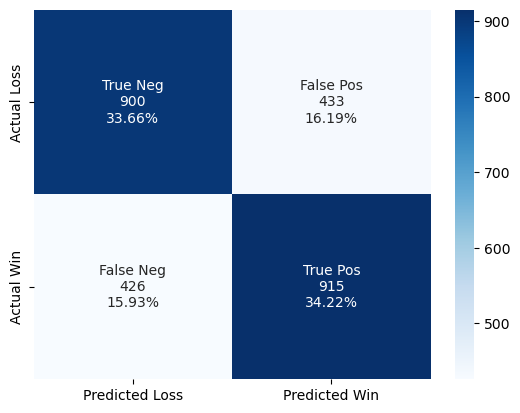

In [65]:
evaluate_classification(gbc_sub, X_val_full_sub, y_val)

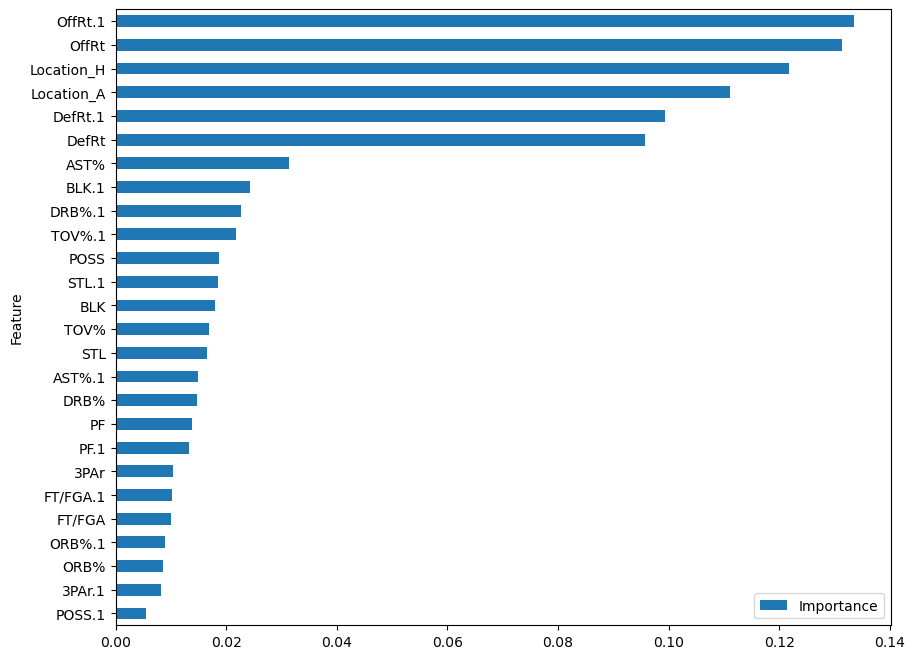

In [66]:
#examining variable importance
coefficients = gbc_sub.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train_full_sub.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [67]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
21      POSS.1    0.005470
20      3PAr.1    0.008147
4         ORB%    0.008629
16      ORB%.1    0.008907
5       FT/FGA    0.009949
17    FT/FGA.1    0.010203
8         3PAr    0.010404
14        PF.1    0.013324
2           PF    0.013747
6         DRB%    0.014656
19      AST%.1    0.014847
0          STL    0.016559
3         TOV%    0.016987
1          BLK    0.018036
12       STL.1    0.018461
9         POSS    0.018752
15      TOV%.1    0.021771
18      DRB%.1    0.022648
13       BLK.1    0.024374
7         AST%    0.031294
11       DefRt    0.095799
23     DefRt.1    0.099399
24  Location_A    0.111114
25  Location_H    0.121694
10       OffRt    0.131392
22     OffRt.1    0.133435


In [68]:
#comparing the reduced variable model to the optimized full variable model
compare_classification(hyp_gbc, gbc_sub, X_val_full, X_val_full_sub, y_val)


           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6839940164547494     0.6787584143605087     -0.005235602094240788      Accuracy: Model 1 better
AUC:  0.7391730482956309     0.7353292461817915     -0.0038438021138393896      AUC: Model 1 better


## The optimized gradient boosted tree model still performs best, lets try optimizing the reduced variable model

In [69]:
#assign values for hyperopt to explore as it searches for optimal parameters
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 1,1000,1)),
    'loss': hp.choice('loss', ['log_loss','exponential']),
    'learning_rate': hp.uniform('learning_rate', 0.0,0.5),
    'criterion': hp.choice('criterion', ['friedman_mse','squared_error']),
    'max_depth': hp.choice('max_depth',
                           [None, scope.int(hp.quniform('max_depth_uni', 1,100,1))]),
    'max_features': hp.choice('max_features',
        [None, 'log2', 'sqrt', hp.uniform('max_features_uni', 0.0,1.0)]),
    'min_samples_split': hp.uniform('min_samples_split', 0.0, 0.9),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0,1.0),
    'subsample': hp.uniform('subsample', 0.0,1.0),
    'ccp_alpha': hp.uniform('ccp_alpha', 0,0.1),
    'random_state': 0
}

In [70]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    
    model = GradientBoostingClassifier(**params)
    model.fit(X_train_full_sub, y_train)
    
    y_pred_train = model.predict(X_train_full_sub)
    y_pred_val = model.predict(X_val_full_sub)
    
    acc = accuracy_score(y_val, y_pred_val)
    
    if acc > best:
        best = acc
        print('new best:', best, params, count)
        
    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'train_loss': -accuracy_score(y_train, y_pred_train)}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=500, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                       
0.5014958863126402                                                              
{'ccp_alpha': 0.04841849058384911, 'criterion': 'squared_error', 'learning_rate': 0.16199951785771693, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 0.6517423997488939, 'min_samples_split': 0.7955339629253539, 'n_estimators': 620, 'random_state': 0, 'subsample': 0.8136554076402878}
1                                                                               
new best:                                                                       
0.6514584891548242                                                              
{'ccp_alpha': 0.015821390200459175, 'criterion': 'squared_error', 'learning_rate': 0.46622574683653734, 'loss': 'exponential', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 0.33486009438808095, 'min_samples_split': 0.183855826809146, 'n_estimators': 988, 'random_s

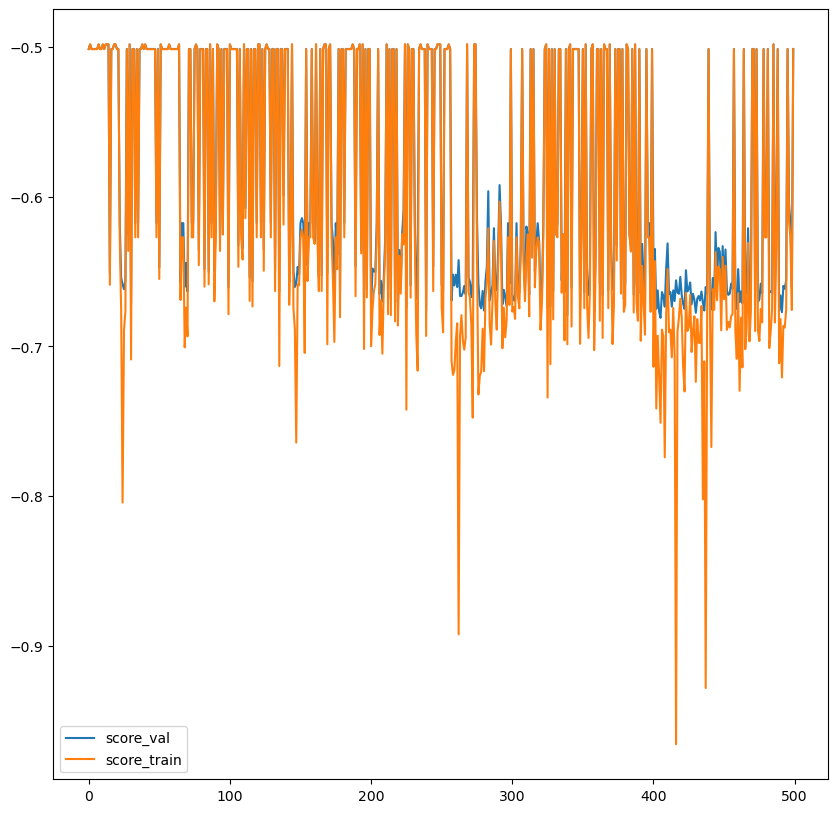

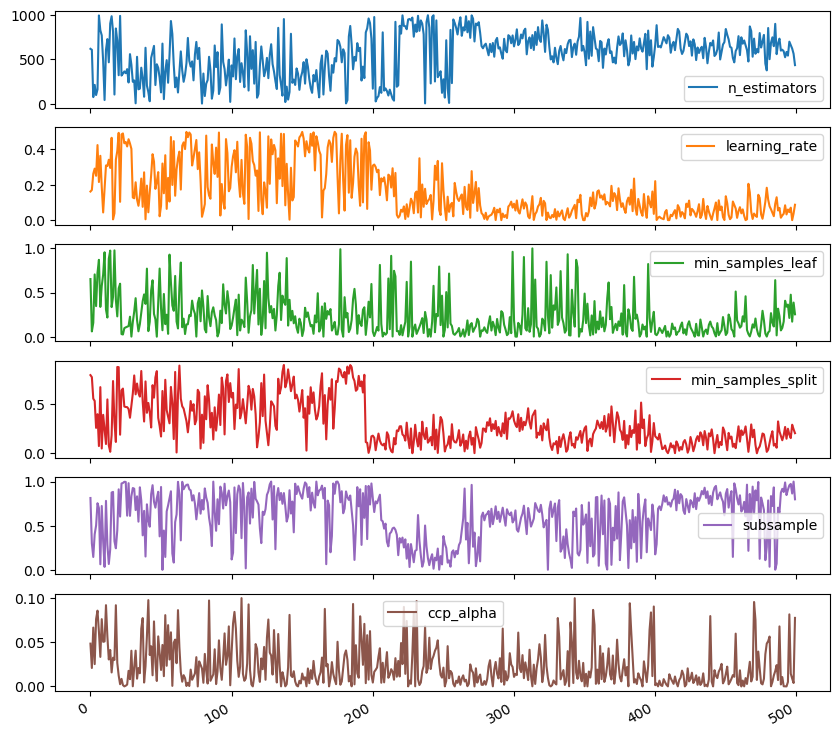

In [71]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss']] for x in trials.trials])

results2=np.array([x['train_loss'] for x in trials.results])

results_loss=pd.DataFrame(results,
                           columns=['score_val'])

results_loss['score_train'] = results2

results_loss.plot(subplots=False,figsize=(10, 10))




results3=np.array([[x['misc']['vals']['n_estimators'][0],
                   x['misc']['vals']['learning_rate'][0],
                   x['misc']['vals']['min_samples_leaf'][0],
                   x['misc']['vals']['min_samples_split'][0],
                   x['misc']['vals']['subsample'][0],
                   x['misc']['vals']['ccp_alpha'][0]] for x in trials.trials])

results_df1=pd.DataFrame(results3,
                           columns=['n_estimators', 'learning_rate', 'min_samples_leaf',
                                   'min_samples_split',
                                   'subsample', 'ccp_alpha'])

results_df1.plot(subplots=True,figsize=(10, 10))


plt.show()

In [72]:
#examine best parameters
best3 = space_eval(space, best)
best3

{'ccp_alpha': 0.0005093649871319456,
 'criterion': 'friedman_mse',
 'learning_rate': 0.008661300052524974,
 'loss': 'exponential',
 'max_depth': 16,
 'max_features': None,
 'min_samples_leaf': 0.04200871954548095,
 'min_samples_split': 0.042459542602767616,
 'n_estimators': 693,
 'random_state': 0,
 'subsample': 0.747687160682401}

In [73]:
#train model using best parameters from search
hyp_gbc_sub = GradientBoostingClassifier(n_estimators = best3['n_estimators'],
                                    loss = best3['loss'],
                                    learning_rate = best3['learning_rate'],
                                    criterion = best3['criterion'],
                                    max_depth = best3['max_depth'],
                                    max_features = best3['max_features'],
                                     min_samples_leaf = best3['min_samples_leaf'],
                                     min_samples_split = best3['min_samples_split'],
                                    subsample = best3['subsample'],
                                     ccp_alpha = best3['ccp_alpha'],
                                    random_state = best3['random_state'])

hyp_gbc_sub.fit(X_train_full_sub, y_train)

GradientBoostingClassifier(ccp_alpha=0.0005093649871319456,
                           learning_rate=0.008661300052524974,
                           loss='exponential', max_depth=16,
                           min_samples_leaf=0.04200871954548095,
                           min_samples_split=0.042459542602767616,
                           n_estimators=693, random_state=0,
                           subsample=0.747687160682401)

In [74]:
y_pred = hyp_gbc_sub.predict(X_train_full_sub)
print('Training Data Classification Report for estimator: ',
      str(hyp_gbc_sub).split('(')[0])
print('\n', classification_report(y_train, y_pred))


Training Data Classification Report for estimator:  GradientBoostingClassifier

               precision    recall  f1-score   support

           0       0.75      0.75      0.75      3197
           1       0.75      0.75      0.75      3218

    accuracy                           0.75      6415
   macro avg       0.75      0.75      0.75      6415
weighted avg       0.75      0.75      0.75      6415



In [75]:
y_pred = hyp_gbc_sub.predict(X_val_full_sub)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_gbc_sub).split('(')[0])
print('\n', classification_report(y_val, y_pred))


Test Data Classification Report for estimator:  GradientBoostingClassifier

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1333
           1       0.68      0.68      0.68      1341

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.681002243829469 

Classification Report

              precision    recall  f1-score   support

           0     0.6802    0.6797    0.6799      1333
           1     0.6818    0.6823    0.6821      1341

    accuracy                         0.6810      2674
   macro avg     0.6810    0.6810    0.6810      2674
weighted avg     0.6810    0.6810    0.6810      2674



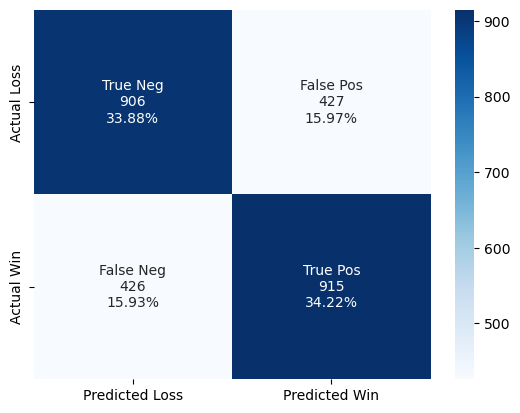

In [76]:
evaluate_classification(hyp_gbc_sub, X_val_full_sub, y_val)

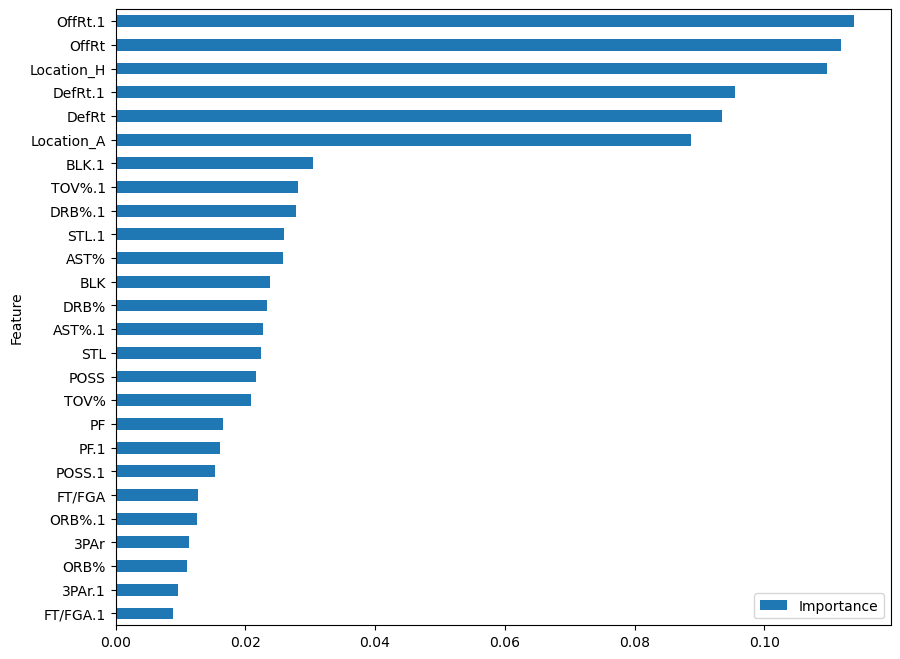

In [77]:
#examining variable importance
coefficients = hyp_gbc_sub.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train_full_sub.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()


In [78]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
17    FT/FGA.1    0.008853
20      3PAr.1    0.009689
4         ORB%    0.011049
8         3PAr    0.011395
16      ORB%.1    0.012541
5       FT/FGA    0.012738
21      POSS.1    0.015365
14        PF.1    0.016038
2           PF    0.016503
3         TOV%    0.020931
9         POSS    0.021669
0          STL    0.022360
19      AST%.1    0.022659
6         DRB%    0.023345
1          BLK    0.023861
7         AST%    0.025870
12       STL.1    0.025888
18      DRB%.1    0.027854
15      TOV%.1    0.028059
13       BLK.1    0.030457
24  Location_A    0.088747
11       DefRt    0.093491
23     DefRt.1    0.095400
25  Location_H    0.109690
10       OffRt    0.111801
22     OffRt.1    0.113749


In [80]:
#comparing the optimized reduced variable model to the optimized full variable model
compare_classification(hyp_gbc, hyp_gbc_sub, X_val_full, X_val_full_sub, y_val)


           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6839940164547494     0.681002243829469     -0.0029917726252804977      Accuracy: Model 1 better
AUC:  0.7391730482956309     0.7392172427894446     4.4194493813654034e-05      AUC: Model 2 better


## The optimized gradient boosted tree model with the full variable still performs the best.

## Now that we have all of our models optimized, we can finally evaluate how they perform on the test data

In [81]:
mods = [gbc,
        hyp_gbc,
        gbc_rfe,
        hyp_gbc_rfe,
        gbc_sub,
        hyp_gbc_sub]

feats_test = [X_test_full,
              X_test_full,
              X_test_full_rfe,
              X_test_full_rfe,
              X_test_full_sub,
              X_test_full_sub]


feats_val = [X_val_full,
             X_val_full,
             X_val_full_rfe,
             X_val_full_rfe,
             X_val_full_sub,
             X_val_full_sub]


test_evaluation = evaluate_test(models = mods,
                                test_features = feats_test,
                                val_features = feats_val,
                                test_outcomes=y_test,
                                val_outcomes=y_val,
                                sort_var = 'acc')



In [82]:
test_evaluation

,model_name,model,data_name,data,test_acc,val_acc,test_auc,val_auc,test_acc_rank,test_auc_rank
4,gbc_sub,([DecisionTreeRegressor(criterion='friedman_ms...,X_test_full_sub,"{'STL': {0: -0.11828501075573525, 1: 0.2579685...",0.689526,0.678758,0.750306,0.735329,1.0,3.0
1,hyp_gbc,([DecisionTreeRegressor(ccp_alpha=0.0009414359...,X_test_d,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.687032,0.683994,0.750649,0.739173,2.0,2.0
2,gbc_rfe,([DecisionTreeRegressor(criterion='friedman_ms...,X_test_full_rfe,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.683915,0.681750,0.751747,0.736119,3.0,1.0
0,gbc,([DecisionTreeRegressor(criterion='friedman_ms...,X_test_d,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.681421,0.682872,0.748286,0.735380,4.5,4.0
5,hyp_gbc_sub,([DecisionTreeRegressor(ccp_alpha=0.0005093649...,X_test_full_sub,"{'STL': {0: -0.11828501075573525, 1: 0.2579685...",0.681421,0.681002,0.748149,0.739217,4.5,5.0
3,hyp_gbc_rfe,([DecisionTreeRegressor(ccp_alpha=4.4213943939...,X_test_full_rfe,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.677057,0.683994,0.745737,0.737889,6.0,6.0


In [ ]:
best_index = test_evaluation.index.values.astype(int)[0]
best_model = test_evaluation['model'].loc[best_index]
best_params = test_evaluation['model'].loc[best_index].get_params()
best_data = pd.DataFrame(test_evaluation['data'].loc[best_index])

In [ ]:
best_model

# Conclusion

## After exploring the variable relationships and variable importance graphs, it appears there playing location and offensive and defense rating are the most valuable features. This makes sense when you consider 'home court advantage' as well as the fact that offensive and defense rating take into account a multitude of both offensive and defense statistics. The reduced variable optimized model performed best on the test data

## Next notebook will explore using a XGradient boosting model